# Setup

In [2]:
############################################################################################################################ 
# Get the latest CREST files for each ID within the target folder (dirname)

from pathlib import Path
import json
from sqlite3 import connect as sqlite3_connect
from sqlite3 import DatabaseError
from igraph import Graph as ig_Graph
from igraph import plot as ig_plot
from scipy.spatial.distance import cdist
from random import choice as random_choice
from itertools import combinations
from numpy import array, unravel_index, argmin, mean
import random
import numpy as np
from copy import deepcopy
import itertools
from datetime import datetime
from time import time
import neuroglancer
from webbrowser import open as wb_open
from webbrowser import open_new as wb_open_new
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm

# from eCREST_cli_beta import ecrest, import_settings
from eCREST_cli import ecrest, import_settings

The 'ecrest' class has been imported from eCREST_cli.py

An instance of this object will be able to:
- open an neuroglancer viewer for proofrieading (see "Proofread using CREST")
    - add-remove segments (using graph feature for efficiency)
    - format itself and save itself as a CREST-style .json
- convert from neuroglancer json (see "Convert From Neuroglancer to eCREST")
    - format itself and save itself as a CREST-style .json
    


### Import settings

If you save a copy of settings_dict.json (found in the "under construction" directory of eCREST repo) locally somewhere outside the repo (like in your save_dir), then you can use the following code cell to import. This avoids needing to re-type the save_dir and db_path each time you "git pull" updates from the repo to this notebook.

In [3]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

In [4]:
dirpath = Path(settings_dict['save_dir'])
# dirpath = "/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network"

## Get all cells info

In [103]:
nodes = [child.name.split('_')[2] for child in sorted(dirpath.iterdir()) 
         if (child.name[0]!='.') & (child.is_file())] # ignore hidden files]

nodefiles = dict()
for child in sorted(dirpath.iterdir()):
    if (child.name[0]!='.') & (child.is_file()):
        nodefiles[child.name.split('_')[2]] = child

In [104]:
cell_type = {}
not_typed = []
for x in nodes:
    cell = ecrest(settings_dict,filepath = nodefiles[x],launch_viewer=False)
    cell_type[x] = cell.get_ctype('manual') 
    if (cell.get_ctype('manual') == []) | (cell.get_ctype('manual') == ''):
        cell_type[x]=''
        not_typed.append(x)# print(f'cell {x} is not cell-typed in json')
        
print('the following cells are not typed in the main network')
print(not_typed)        
        

the following cells are not typed in the main network
['214799227', '214799227', '215988767', '215988767', '300643106', '300643106', '308504510', '45356019', '45444904', '47537491', '48619460']


In [22]:
# [(k,v) for k,v in cell_type.items() if v == 'grc']

In [ ]:
file_size = {}
for x in nodes:
    file_size[x] = nodefiles[x].stat().st_size
    

In [ ]:
soma_size = {}
for x in nodes:
    cell = ecrest(settings_dict,filepath = nodefiles[x],launch_viewer=False)
    all_segs = [a for b in cell.cell_data['base_segments'].values() for a in b]
    if len(cell.cell_data['base_segments']['unknown']) < len(all_segs):
        soma_size[x]=len(cell.cell_data['base_segments']['unknown'])
    if len(cell.cell_data['base_segments']['unknown']) == len(all_segs):
        soma_size[x]=np.NaN
        # print(f'structures not labeled for {cell.cell_data["metadata"]["main_seg"]["base"]}')



<AxesSubplot:xlabel='type', ylabel='f_size'>

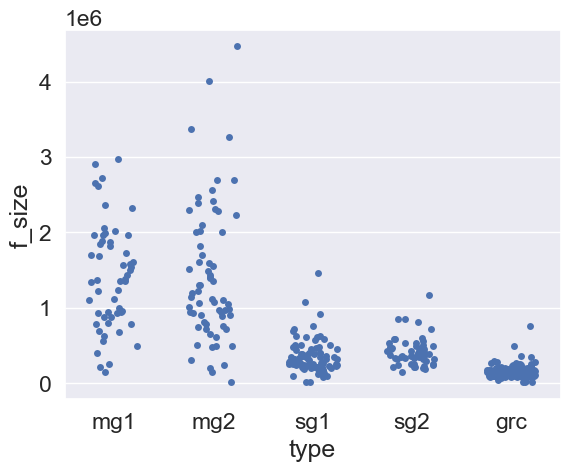

In [1056]:
df = pd.DataFrame.from_dict(file_size,orient='index',columns=['f_size']).reset_index()

type_list=[]
for k in df['index']:
    type_list.append(cell_type[k])

df['type'] = type_list

network_types = ['mg1','mg2','sg1','sg2','grc']
df = df[df['type'].isin(network_types)]

sns.stripplot(data=df, y="f_size", x="type",jitter=0.25)

<AxesSubplot:xlabel='type', ylabel='soma_size'>

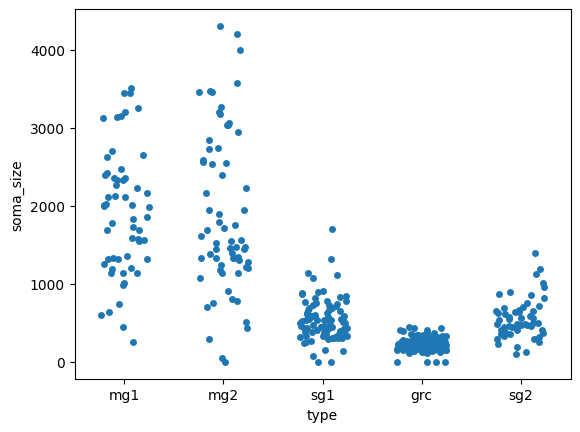

In [16]:
df = pd.DataFrame.from_dict(soma_size,orient='index',columns=['soma_size']).reset_index()

type_list=[]
for k in df['index']:
    type_list.append(cell_type[k])

df['type'] = type_list

network_types = ['mg1','mg2','sg1','sg2','grc']
df = df[df['type'].isin(network_types)]

sns.stripplot(data=df, y="soma_size", x="type",jitter=0.25)

In [6]:
# [k for k,v in cell_type.items() if v == 'sgx']

In [ ]:
# # # IF NEED TO CELL TYPE....


# json_path = Path(settings_dict['save_dir'])
# filename = 'cell_graph_644143297__2023-04-18 20.22.35.json'
# filepath = json_path / filename

# crest = ecrest(settings_dict,filepath= filepath)#, launch_viewer=False)


# # Assign the cell type and which method you are using (manual or auto)
# cell_type = 'mg1'
# method = 'manual'

# ## Do not edit
# crest.define_ctype(cell_type,method)

# crest.save_cell_graph(directory_path = filepath.parent, file_name=filepath.name, save_to_cloud=False); 

In [96]:
search_key = 'Gran'
dict(filter(lambda item: search_key in item[1], cell_type.items()))

{}

In [95]:
search_key = 'gran'
dict(filter(lambda item: search_key in item[1], cell_type.items()))
# [val for key, val in cell_type.items() if val in search_key]

{}

## Get all segments

In [105]:
# Create a base_segments dictionary of all reconstructed cells 

base_segments = {}
for x in nodes:
    # if cell_type[x] in network_types: # if do this, you can't check if the post-syn segments exist as a reconstruction
    cell = ecrest(settings_dict,filepath = nodefiles[x])#,launch_viewer=False)
    base_segments[cell.cell_data['metadata']['main_seg']['base']] = cell.cell_data['base_segments']
    try:
        assert cell.cell_data['metadata']['main_seg']['base'] == x
    except:
        print(x,cell.cell_data['metadata']['main_seg']['base'])

## Build Graph

In [106]:
network_types = set([v for v in cell_type.values()])#['mg1','mg2','lg','lf','sg1','sg2','sgx','grc','aff']

In [107]:
synanno_type = 'pre-synaptic'
vx_sizes = [16, 16, 30]

## find edges and set the cell-structure attribute of the edge based on which part of the cell the edge goes to
edge_list = []

with tqdm(total=len(nodes)) as pbar:
    for x_pre in nodes:
        pbar.update(1)
        if cell_type[x_pre] in network_types:
            
            # if the node has post-synaptic annotations (the current cell is assumed pre-synaptic)
            pre = ecrest(settings_dict,filepath = nodefiles[x_pre])#,launch_viewer=False)
            if pre.cell_data['end_points'][synanno_type] != []:
                # for each synapse
                for syn_ in pre.cell_data['end_points'][synanno_type]:
                    try:
                        post_seg = syn_[3]
                        syn_ = array([int(syn_[i]/vx_sizes[i]) for i in range(3)])

                        # go through each other nodes
                        for x_post in nodes:
                            if cell_type[x_post] in network_types:
                                post = base_segments[x_post] 
                                for k,v in post.items():
                                    for v_ in list(v): #find keys (can be multiple on the same cell) for matching segment ids
                                        if post_seg == v_: 
                                            # add edge to the graph between current node and matching node
                                            
                                            edge_list.append([x_pre,x_post,k,syn_[0],syn_[1],syn_[2]])
                                            

                    except IndexError as msg:
                        cellid = x_pre
                        print(msg, f'for cell {cellid} synapse at {array([int(syn_[i]/vx_sizes[i]) for i in range(3)])} has no segment id')

            else:
                continue


100%|██████████████████████████████████████████████████████████████| 1374/1374 [05:31<00:00,  4.14it/s]


### Synapses dataframe

In [108]:
df_syn = pd.DataFrame(edge_list,columns = ['pre','post','structure','x','y','z'])

for i,r in df_syn.iterrows():
    df_syn.loc[i,'pre_type']=cell_type[df_syn.loc[i,'pre']]
    df_syn.loc[i,'post_type']=cell_type[df_syn.loc[i,'post']]

#### Ignore cell structure

If just want different cell pairs to count as unique (ignore morphology), use the following cell

In [109]:
df_syn.drop(['structure'],axis=1, inplace=True)


#### save df_syn

In [110]:
savepath = Path('/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network/graphs/')

df_syn.to_csv(savepath / 'df_presyn.csv')